In [1]:
%matplotlib inline
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

/home/john/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dataset = pd.read_csv('../data/higgs_small.txt')
# dataset = pd.read_csv('../data/higgs_full.txt')
np.random.shuffle(dataset.values)

# X = dataset.iloc[:,:28]
# Y = dataset.iloc[:,28]

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(
    dataset.iloc[:,:28], dataset.iloc[:,28], test_size=test_size, random_state=seed)



scaler1st = StandardScaler()
X_train = scaler1st.fit_transform(X_train)
X_test = scaler1st.fit_transform(X_test)

# dataset = np.loadtxt('../data/higgs_small.txt',delimiter=',', skiprows=1)

# np.random.shuffle(dataset)

# X = dataset[:, 0:28]
# Y = dataset[:, 28]

# # split data into train and test sets
# seed = 7
# test_size = 0.33
# X_1, X_2, y_train, y_test = train_test_split(
#     X, Y, test_size=test_size, random_state=seed)



# scaler1st = StandardScaler()
# X_train = scaler1st.fit_transform(X_1)
# X_test = scaler1st.fit_transform(X_2)


In [3]:
print(dataset.head())

   lepton_pT  lepton_eta  lepton_phi  missing_energy_magnitude  \
0   0.869293   -0.635082    0.225690                  0.327470   
1   0.907542    0.329147    0.359412                  1.497970   
2   0.798835    1.470640   -1.635970                  0.453773   
3   1.105010    0.321356    1.522400                  0.882808   
4   0.409391   -1.884680   -1.027290                  1.672450   

   missing_energy_phi  jet_1_pt  jet_1_eta  jet_1_phi  jet_1_b_tag  jet_2_pt  \
0           -0.689993  0.754202  -0.248573  -1.092060      0.00000  1.374990   
1           -0.313010  1.095530  -0.557525  -1.588230      2.17308  0.812581   
2            0.425629  1.104870   1.282320   1.381660      0.00000  0.851737   
3           -1.205350  0.681466  -1.070460  -0.921871      0.00000  0.800872   
4           -1.604600  1.338010   0.055427   0.013466      2.17308  0.509783   

   ...    jet_4_phi  jet_4_b_tag      m_jj     m_jjj      m_lv     m_jlv  \
0  ...    -0.045767      3.10196  1.353760  0.

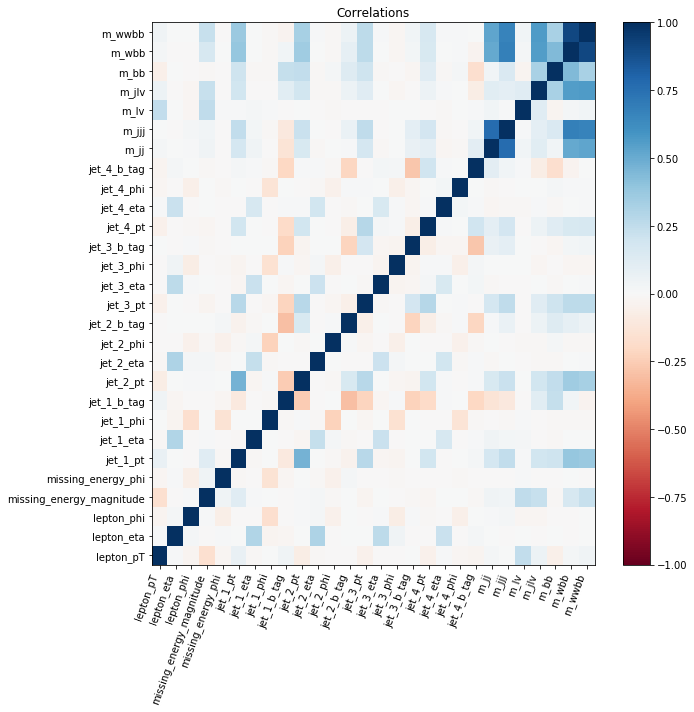

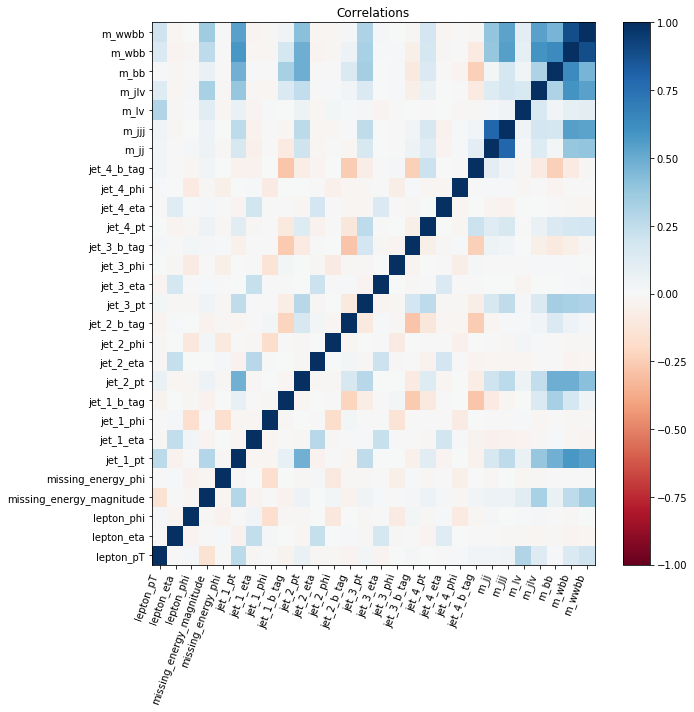

In [4]:
bg = dataset.label == 0
sig = dataset.label ==  1

def correlations(data):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr()
    
    fig, ax1 = plt.subplots(ncols=1, figsize=(10, 10))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    
# remove the y column from the correlation matrix
# after using it to select background and signal
correlations(dataset[sig].drop('label', 1))
correlations(dataset[bg].drop('label', 1))


# clearing dataset to free memory
dataset = None

In [5]:
clf = RandomForestClassifier(n_estimators=100,max_depth=5,n_jobs=-1)
result = clf.fit(X_train,y_train)
y_pred = result.predict_proba(X_test)[:, 1]

train_predict = result.predict_proba(X_train)
test_predict = result.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_predict[:,1])
auc_rf = auc(fpr, tpr)

# Saving the classifier

We can save the classifier using the pickle library and we can load it later.


In [6]:
import pickle
filename = 'rf_model.pkl'
pickle.dump(clf,open(filename,'wb'))

# loaded_model = pickle.load(open(filename,'rb'))


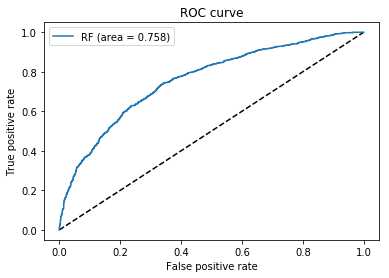

In [7]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

0.23394417335779294


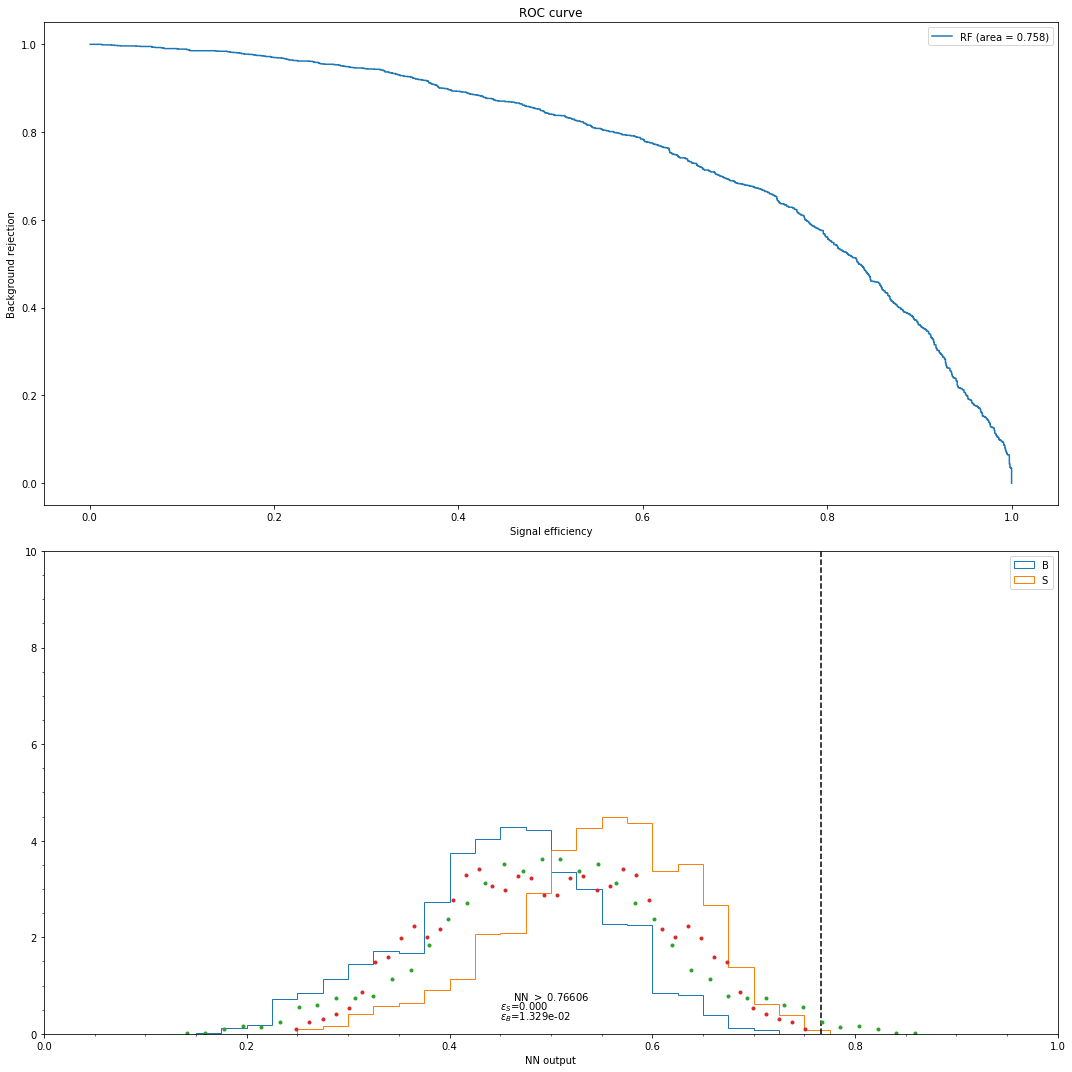

In [8]:
FullThresholdSet = thresholds[np.argmin(abs(fpr-7e-5))]
print(1 - FullThresholdSet)


plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.plot(tpr, (1 - fpr), label='RF (area = {:.3f})'.format(auc_rf))
plt.legend(loc='lower right', frameon=False, fontsize=12)
plt.xlabel('Signal efficiency')
plt.ylabel('Background rejection')
plt.title('ROC curve')
plt.legend(loc='best')
# plt.xscale('log')
# plt.ylim(1e-6,1)

plt.subplot(2, 1, 2)
plt.hist(test_predict[y_test == 0,1], bins=40, range=(
    0, 1), density=True, histtype='step', label='B')
plt.hist(test_predict[y_test == 1,1], bins=40, range=(
    0, 1), density=True, histtype='step', label='S')
# plt.yscale('log')
plt.legend(loc='best')
plt.xlim(0, 1)
plt.ylim(1e-3, 1e1)
plt.vlines(FullThresholdSet, 1e-3, 1e3, linestyle='--')
plt.xlabel('NN output')


plt.text(0.5, 0.7, r"NN $>$ {0:.5f}".format(FullThresholdSet), ha='center')
plt.text(0.45, 0.50, r'$\epsilon_{S}$'+'={0:.3f}'.format(float(sum(
    test_predict[y_test == 1] > FullThresholdSet)[0])/sum(y_test == 1)), ha='left')
plt.text(0.45, 0.3, r'$\epsilon_{B}$'+'={0:.3e}'.format(float(sum(
    test_predict[y_test == 0] > FullThresholdSet)[0])/sum(y_test == 0)), ha='left')

countsS, bin_edgesS = np.histogram(
    train_predict[y_train == 0], 40, density=True)
bin_centresS = (bin_edgesS[:-1] + bin_edgesS[1:])/2.
# errS = np.sqrt(countsS)
plt.errorbar(bin_centresS, countsS, fmt='.')

countsB, bin_edgesB = np.histogram(
    train_predict[y_train == 1], 40, density=True)
bin_centresB = (bin_edgesB[:-1] + bin_edgesB[1:])/2.
# errB = np.sqrt(countsB)
plt.errorbar(bin_centresB, countsB, fmt='.')
plt.minorticks_on()
plt.tight_layout()
plt.show()